# Decision Tree on Smart Alert System

In [17]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE


## Process Data and Split 

In [43]:
# Load the dataset
data_folder = Path.cwd() / "data"
csv_analysis = data_folder / "logwNotes.csv"
df = pd.read_csv(csv_analysis)

# Aggregate the data by 5-second intervals 
#Change interval to your desire
df['time_interval'] = (df['second'] - 1) // 5

aggregated_df = df.groupby('time_interval').agg({
    'distance': 'mean',
    'motion': 'mean',
    'lightIntensity': 'mean',
    'occupied': lambda x: x.mode().iloc[0],
    'occupied_note': lambda x: x.mode().iloc[0]
}).reset_index()

# Define features and target
X = aggregated_df[['distance', 'motion', 'lightIntensity', 'occupied']]
y = aggregated_df['occupied_note']

# Split into train and test sets (stratify ensures class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


## Fine Tune Model

In [44]:
# Define parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV to find best parameters based on recall
grid_search = GridSearchCV(
    clf, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1
) 
grid_search.fit(X_train_smote, y_train_smote)

# Get best model
best_clf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Train best model
best_clf.fit(X_train_smote, y_train_smote)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=3, random_state=42)

## Make Predictions & Evaluate


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2122
           1       0.48      0.51      0.49       288

    accuracy                           0.88      2410
   macro avg       0.71      0.72      0.71      2410
weighted avg       0.88      0.88      0.88      2410


Confusion Matrix:
[[1966  156]
 [ 142  146]]

ROC AUC Score: 0.78


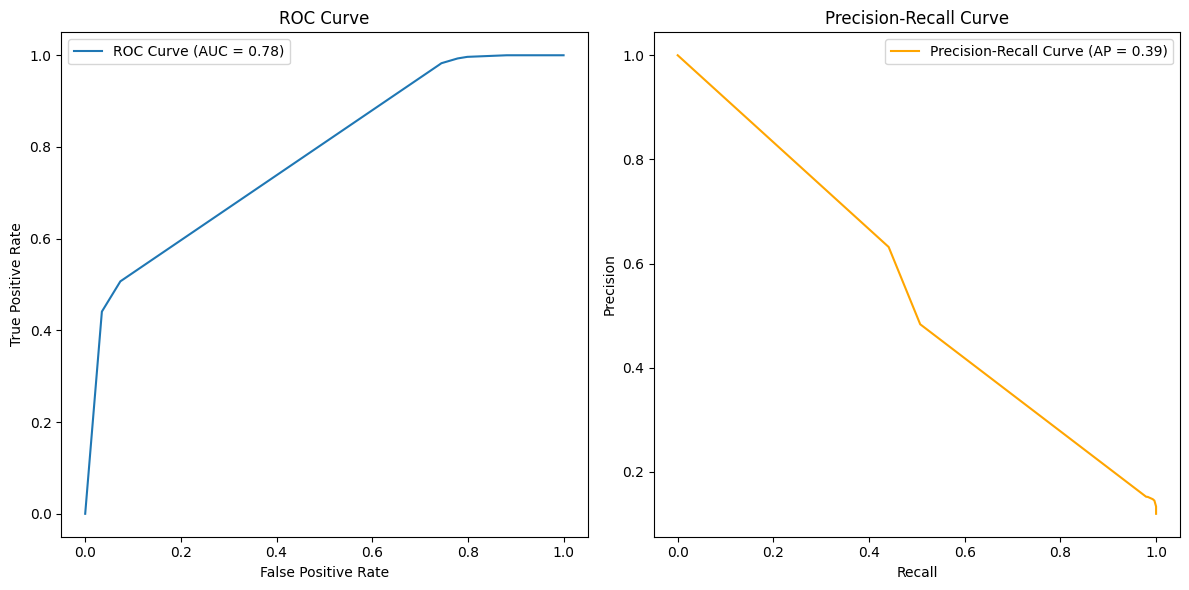

In [46]:
# Make predictions
y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)[:, 1]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.2f}")

plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"Precision-Recall Curve (AP = {avg_precision:.2f})", color='orange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()
